# Optimizing & monochromatizing H41 ($\lambda_{\mathrm{laser}}=1030~\mathrm{nm}$) in Ar for $\eta = 0.75\eta_{\mathrm{opt.}}$

This notebook is a modification of `optimise_ar_1030nm_H41_in_theta.ipynb`. The difference is that we consider $\eta = 0.75\eta_{\mathrm{opt.}}$ as the degree of ionization.

In [1]:
# general imports
import copy
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, Latex
# imports for analytical
import XUV_refractive_index as XUV_index
import XUV_signal_computation2 as XUV_sig
import mynumerics as mn
import harmonic_signal as hs

['Ar_Henke', 'Ar_NIST', 'He_Henke', 'He_NIST', 'Kr_Henke', 'Kr_NIST', 'Ne_Henke', 'Ne_NIST', 'Xe_Henke', 'Xe_NIST']


# Optimisation goal & initial parameters

Our goal is to optimise the absorption-limited monochromatisation of the 41st harmonic in Argon generated by a 1030-nm laser. The dependence of the absorption length in this region is

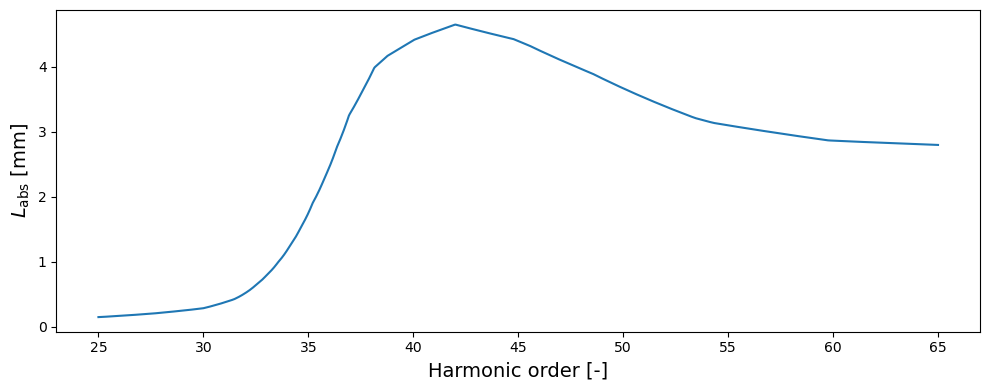

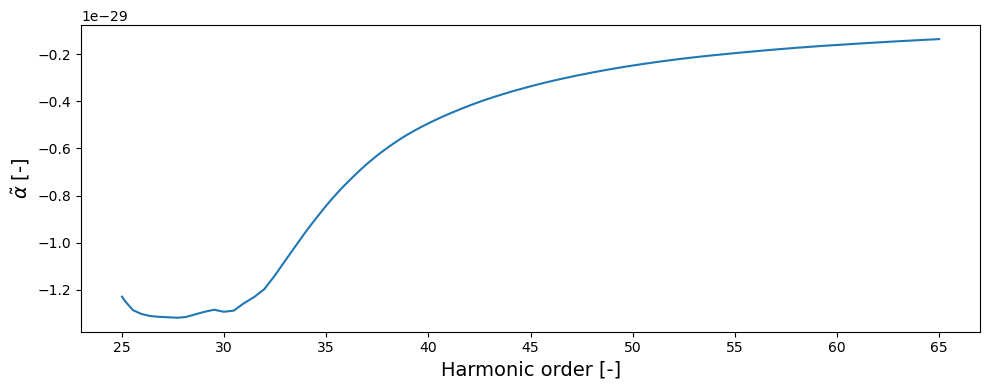

In [2]:
gas_type = 'Ar'
XUV_table_type_absorption = 'Henke' # {Henke, NIST}    
XUV_table_type_dispersion = 'Henke'
H_opt = 41

# laser  
omegaSI = mn.ConvertPhoton(1030e-9, 'lambdaSI', 'omegaSI') 
pressure = 100e-3


parameters = {'XUV_table_type_dispersion': XUV_table_type_dispersion,
              'XUV_table_type_absorption': XUV_table_type_absorption,
              'gas_type': gas_type,
              'omegaSI': omegaSI,
              'Aq' : 1.0}


def asymptotic_signal(p,omega):
    return 4.*((p*parameters['Aq'])**2)*XUV_index.L_abs(omega, pressure, gas_type + '_' + XUV_table_type_absorption)**2


Hgrid_plot = np.linspace(25,65,1000)
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Harmonic order [-]", fontsize=14)
ax.set_ylabel("$L_{\mathrm{abs}}$ [mm]", fontsize=14)

ax.plot(Hgrid_plot, 1e3*XUV_index.L_abs(Hgrid_plot*omegaSI, pressure, gas_type + '_' + XUV_table_type_absorption)) #, color="b", alpha=0.5, label="q + 2")

plt.tight_layout()
fig.savefig('Labs.pdf')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Harmonic order [-]", fontsize=14)
ax.set_ylabel(r"$\tilde{\alpha}$ [-]", fontsize=14)

ax.plot(Hgrid_plot, XUV_index.polarisability(Hgrid_plot*omegaSI, gas_type + '_' + XUV_table_type_dispersion)) #, color="b", alpha=0.5, label="q + 2")

plt.tight_layout()
# fig.savefig('Labs.pdf')
plt.show()

# Contrast as a function of the number of periods while keeping the total length of the medium $3L_{\mathrm{abs}}$

To find the optimising parameters, we use a sample series of sample $l_1=1~\mathrm{mm}$. We investigate the signals and the contrast with the increasing number of periods. We impose the condition that the total length of the gas is $3L_{\mathrm{abs}}$.

c:\git\qpm-code\Article Jupyter\XUV_signal_computation2.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  L_coh = np.abs(np.pi/delta_k1)


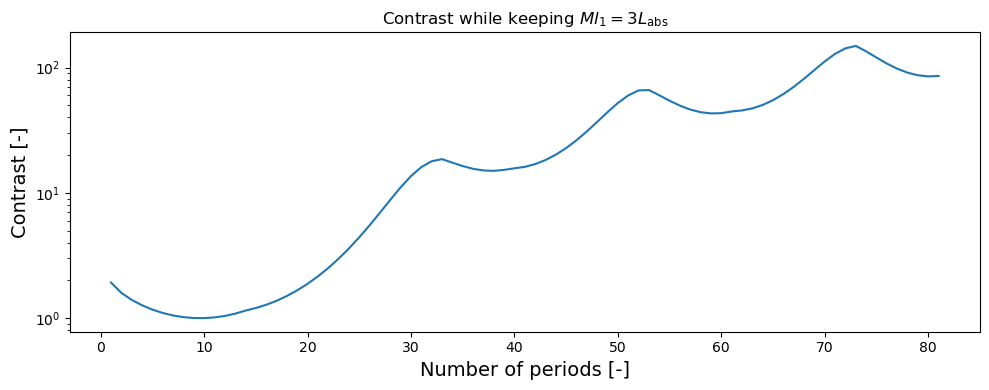

In [3]:
l1=1e-3
pressure_guess = 10e-3
L_abs_factor = 3.
delta_phi = np.pi/H_opt

# H_list = list(np.arange(23,66,2))
M_max = 2*H_opt

M_grid = np.arange(1, M_max)

# find optimal parameters of the generation
eta_opt = XUV_sig.eta_opt(H_opt, parameters)
eta_gen = 0.75*eta_opt # 0.0 # 0.5*eta_opt


H_interest = list(range(H_opt-6,H_opt+7,2)) # list(range(H_opt-24,H_opt+25,2)) # list(range(H_opt-6,H_opt+7,2))
H_compare = copy.deepcopy(H_interest)
H_compare.remove(H_opt)

pressure_grid = np.zeros((len(M_grid),))
zeta_opt = np.empty((len(M_grid),)); xi_opt = np.empty((len(M_grid),))
signal_list = []
contrasts = np.zeros((len(M_grid),))

for k1 in range(len(M_grid)):
    L_abs_p_f = lambda p: M_grid[k1]*l1 - L_abs_factor*XUV_index.L_abs(H_opt*omegaSI, p, gas_type + '_' + XUV_table_type_absorption)
    pressure_grid[k1] = sp.optimize.newton(L_abs_p_f, pressure_guess)
    # print(3*XUV_char.L_abs(gas_type + '_' + XUV_table_type_absorption, Horder_init*omegaSI, pressure_grid[k1]))
    zeta_opt[k1] = XUV_sig.zeta_single_segment(pressure_grid[k1], H_opt, eta_gen, parameters)
    xi_opt[k1] = XUV_sig.xi_calc_pm(-delta_phi,pressure_grid[k1], l1, zeta_opt[k1], eta_gen, H_opt, parameters)
    signal_list.append(
        [XUV_sig.periodic_medium_signal(pressure_grid[k1], zeta_opt[k1], l1, xi_opt[k1], eta_gen, H_calc, M_grid[k1], parameters)[1] for H_calc in H_interest]
        )
    
    contrasts[k1] = XUV_sig.monochrom_function(H_interest, signal_list[k1], H_opt, H_compare, metric='max')

signals = np.asarray(signal_list)
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Number of periods [-]", fontsize=14)
ax.set_ylabel("Contrast [-]", fontsize=14)
ax.semilogy(M_grid, contrasts)

ax.set_title(r'Contrast while keeping $Ml_1 = 3L_{\mathrm{abs}}$') 

plt.tight_layout()
fig.savefig('Contrast_keeping_3Labs.pdf')
plt.show()


This result shows that we reach the contrast around 20 for 11 periods.

# Detailed study of the signal for 11 periods

Using the previous result, we investigate the generation scheme for 11 periods. We show the signals of the harmonics of the interest, the evolution of the contrast with the number of periods. For a comparison, we show also signals & contrasts for halving $l_1$ (with keeping the pressure constant) and doubling the phase jump.

zeta=9.64626520777838e-06
xi=2.604318944004859
zeta2=9.64626520777838e-06
xi2=5.208637888009718
zeta3=9.64626520777838e-06
xi3=5.208637888009718


c:\git\qpm-code\Article Jupyter\XUV_signal_computation2.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  L_coh = np.abs(np.pi/delta_k1)


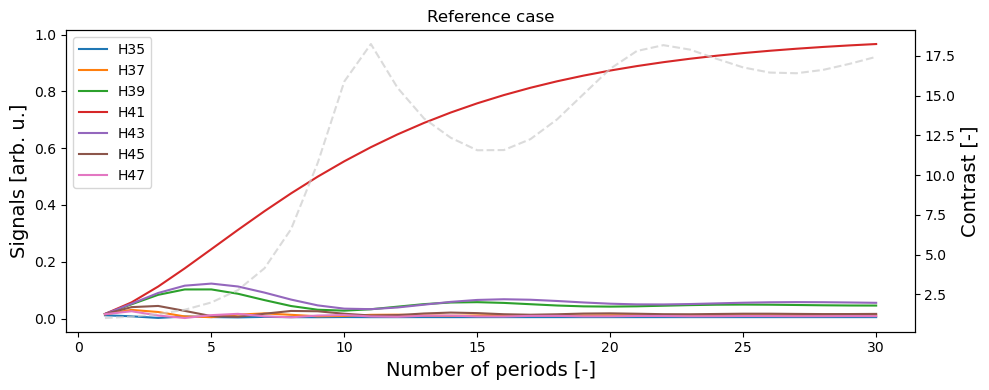

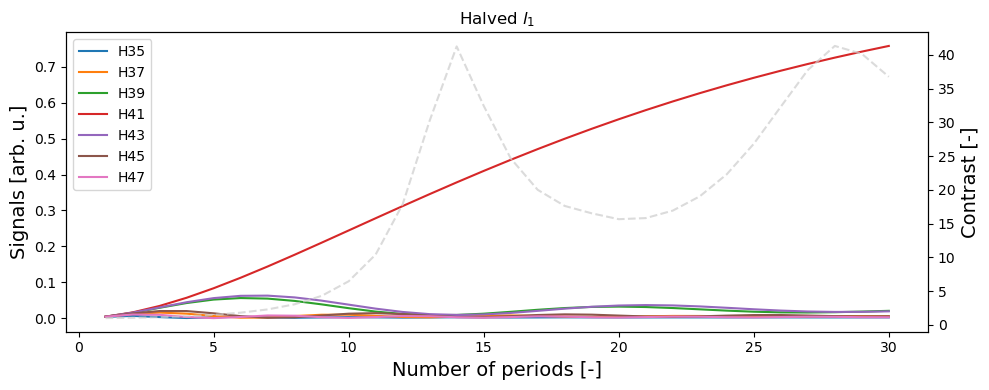

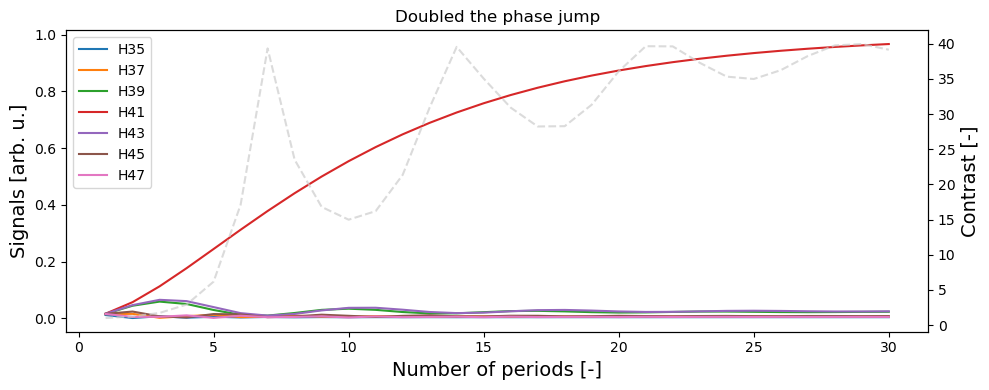

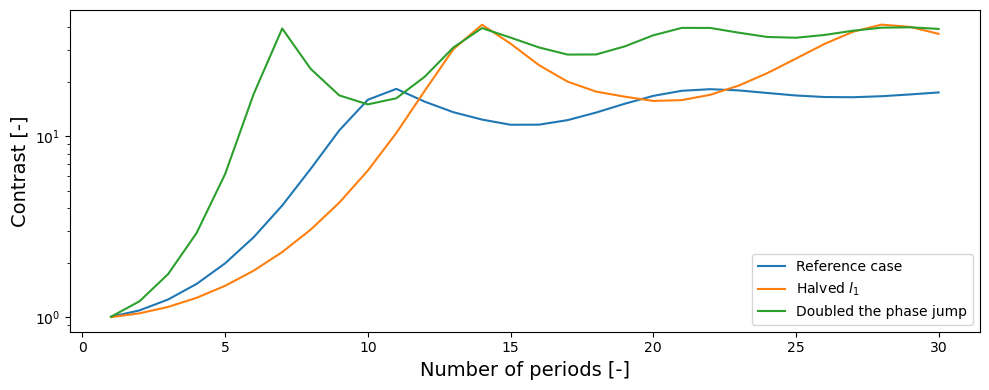

In [4]:
M_3Labs = 11
M_grid = np.arange(1, 31)

L_abs_p_f = lambda p: M_3Labs*l1 - L_abs_factor*XUV_index.L_abs(H_opt*omegaSI, p, gas_type + '_' + XUV_table_type_absorption)
pressure = sp.optimize.newton(L_abs_p_f, pressure_guess)

zeta_opt = XUV_sig.zeta_single_segment(pressure, H_opt, eta_gen, parameters)
xi_opt = XUV_sig.xi_calc_pm(delta_phi,pressure, l1, zeta_opt, eta_gen, H_opt, parameters)
print('zeta='+str(zeta_opt))
print('xi='+str(xi_opt))

# halving pressure
zeta_opt2 = XUV_sig.zeta_single_segment(pressure, H_opt, eta_gen, parameters)
xi_opt2 = XUV_sig.xi_calc_pm(delta_phi,pressure, 0.5*l1, zeta_opt, eta_gen, H_opt, parameters)
print('zeta2='+str(zeta_opt2))
print('xi2='+str(xi_opt2))

# doubling the jump
zeta_opt3 = XUV_sig.zeta_single_segment(pressure, H_opt, eta_gen, parameters)
xi_opt3 = XUV_sig.xi_calc_pm(2.*delta_phi,pressure, l1, zeta_opt, eta_gen, H_opt, parameters)
print('zeta3='+str(zeta_opt3))
print('xi3='+str(xi_opt3))

# signals
signal_list = [XUV_sig.periodic_medium_signal(pressure, zeta_opt, l1, xi_opt, eta_gen, H_calc, M_grid, parameters)[1] for H_calc in H_interest]
signal_list2 = [XUV_sig.periodic_medium_signal(pressure, zeta_opt2, 0.5*l1, xi_opt2, eta_gen, H_calc, M_grid, parameters)[1] for H_calc in H_interest]
signal_list3 = [XUV_sig.periodic_medium_signal(pressure, zeta_opt3, l1, xi_opt3, eta_gen, H_calc, M_grid, parameters)[1] for H_calc in H_interest]


# plot signals
sig_norm = asymptotic_signal(pressure,H_opt*omegaSI)
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Number of periods [-]", fontsize=14)
ax.set_ylabel("Signals [arb. u.]", fontsize=14)
for k1 in range(len(H_interest)):
    ax.plot(M_grid, signal_list[k1]/sig_norm, label= r"H"+str(H_interest[k1]))

ax_right = ax.twinx()
ax_right.set_ylabel("Contrast [-]", fontsize=14)
ax_right.plot(M_grid, XUV_sig.monochrom_function(H_interest, signal_list, H_opt, H_compare, metric='max'), color='0.8', linestyle='--', alpha=0.7)

ax.legend()
ax.set_title("Reference case")

plt.tight_layout()
fig.savefig('Reference_case.pdf')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Number of periods [-]", fontsize=14)
ax.set_ylabel("Signals [arb. u.]", fontsize=14)
for k1 in range(len(H_interest)):
    ax.plot(M_grid, signal_list2[k1]/sig_norm, label= r"H"+str(H_interest[k1]))

ax_right = ax.twinx()
ax_right.set_ylabel("Contrast [-]", fontsize=14)
ax_right.plot(M_grid, XUV_sig.monochrom_function(H_interest, signal_list2, H_opt, H_compare, metric='max'), color='0.8', linestyle='--', alpha=0.7)

ax.legend()

ax.set_title(r"Halved $l_1$")

plt.tight_layout()
fig.savefig('l1_halved.pdf')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Number of periods [-]", fontsize=14)
ax.set_ylabel("Signals [arb. u.]", fontsize=14)
for k1 in range(len(H_interest)):
    ax.plot(M_grid, signal_list3[k1]/sig_norm, label= r"H"+str(H_interest[k1]))

ax_right = ax.twinx()
ax_right.set_ylabel("Contrast [-]", fontsize=14)
ax_right.plot(M_grid, XUV_sig.monochrom_function(H_interest, signal_list3, H_opt, H_compare, metric='max'), color='0.8', linestyle='--', alpha=0.7)

ax.legend()
ax.set_title("Doubled the phase jump")

plt.tight_layout()
fig.savefig('Phase-jump_doubled.pdf')
plt.show()


# contrasts
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Number of periods [-]", fontsize=14)
ax.set_ylabel("Contrast [-]", fontsize=14)
ax.semilogy(M_grid, XUV_sig.monochrom_function(H_interest, signal_list, H_opt, H_compare, metric='max'), label = 'Reference case')
ax.semilogy(M_grid, XUV_sig.monochrom_function(H_interest, signal_list2, H_opt, H_compare, metric='max'), label = r"Halved $l_1$")
ax.semilogy(M_grid, XUV_sig.monochrom_function(H_interest, signal_list3, H_opt, H_compare, metric='max'), label = "Doubled the phase jump")
plt.legend()

plt.tight_layout()
fig.savefig('Contrasts_comparisons.pdf')
plt.show()



These results provided further insight in the bould-up of the signal & contrast in the case of our interest. In particular, we show the effects of halving the gas-jet length and doubling the phase-jump. These conclusion are inferred from a comparison with the reference case:
1) If we use halved $l_1$, both signal and the contrast grow slower with increasing the number of periods. However the asymptotic contrast is higher that in the reference case. It shows that if the setup allows for adding more jets, the resulting scheme provides a better contrast. We observe also that the slower growth of the contrast is caused by the larger number of periods needed to suppress the signal of the neighbouring harmonics. This conclusion is consistent with the fact, that the absorption within a single jet becomes weaker and we are closer to the analytic study neglecting the absorption.
2) If we double the phase-jump, we obtain the same signal for the optimised harmonic after a fixed number of periods. Furthermore, the build-up of the contrast is much faster as the neighbouring harmonics are suppressed faster as functions of the number of periods. Finally, the asymptotic contrast is the same as in the case with the halved $l_1$, which is consistent with the analytic derivation.

Furthemore, $\zeta$ is the same for all these regimes. The only difference is in $\xi$. Since the optimising condition for $\xi$ scales with the ratio $\Delta \phi / l_1$ (where $\Delta \phi$ is the phase-jump), we have the same values of $\xi$ for either halving $l_1$ or doubling $\Delta \phi$.



c:\git\qpm-code\Article Jupyter\XUV_signal_computation2.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  L_coh = np.abs(np.pi/delta_k1)


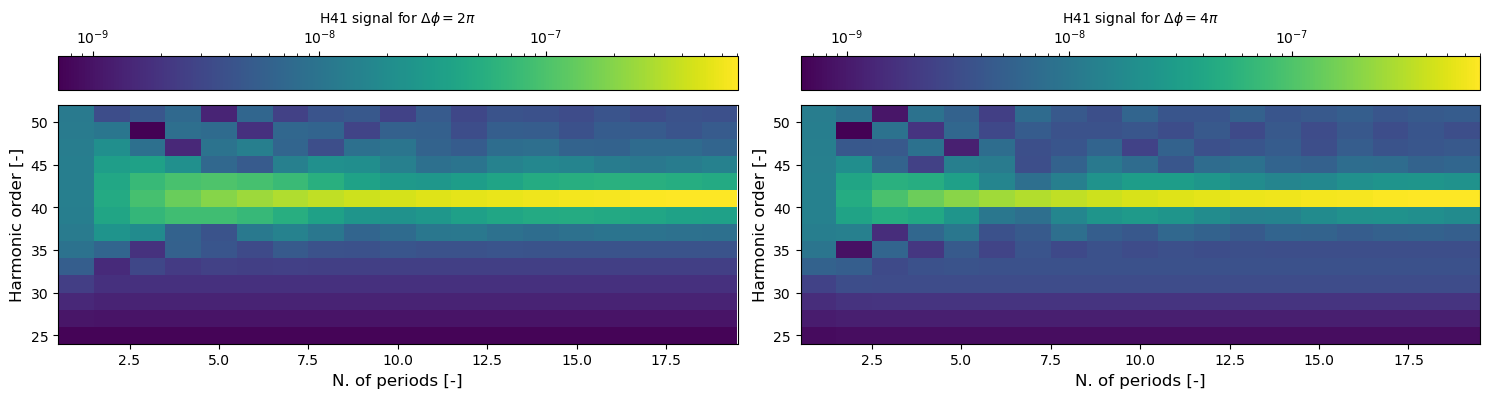

In [5]:
Hgrid_plot = np.arange(25,52,2) # 
M_plot = np.arange(1,20,1) # [67, 100, 200]


signals=np.zeros((len(Hgrid_plot),len(M_plot)))

for k1 in range(len(Hgrid_plot)):
    signals[k1,:] = XUV_sig.periodic_medium_signal(pressure, zeta_opt, l1, xi_opt, eta_gen, Hgrid_plot[k1], M_plot, parameters)[1]

import matplotlib.colors as colors

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
# im = ax[0].pcolormesh(M_plot, Hgrid_plot, signals)
im = ax[0].pcolormesh(M_plot, Hgrid_plot, signals, norm=colors.LogNorm(vmin=1e-3*signals.max(), vmax=signals.max()))
ax[0].set_xlabel(r"N. of periods [-]", fontsize=12)
ax[0].set_ylabel(r"Harmonic order [-]", fontsize=12)
cbar = plt.colorbar(im, ax=ax[0],orientation='horizontal',location='top')
cbar.set_label('H'+str(H_opt)+r' signal for $\Delta \phi = 2\pi$')

for k1 in range(len(Hgrid_plot)):
    signals[k1,:] = XUV_sig.periodic_medium_signal(pressure, zeta_opt3, l1, xi_opt3, eta_gen, Hgrid_plot[k1], M_plot, parameters)[1]


# im = ax[1].pcolormesh(M_plot, Hgrid_plot, signals)
im = ax[1].pcolormesh(M_plot, Hgrid_plot, signals, norm=colors.LogNorm(vmin=signals.min(), vmax=signals.max()))
ax[1].set_xlabel(r"N. of periods [-]", fontsize=12)
ax[1].set_ylabel(r"Harmonic order [-]", fontsize=12)
cbar = plt.colorbar(im, ax=ax[1],orientation='horizontal',location='top')
cbar.set_label('H'+str(H_opt)+r' signal for $\Delta \phi = 4\pi$')

plt.tight_layout()
# fig.savefig('Harmonic_comb_evolution2.pdf')
plt.show()

# The stability of the scheme with respect to: ionisation, pressure and $\zeta$

Finally, we investigate the stability of the scheme considering the pressure, geom. phase and ionisation. We illustrate it by:
1) showing the signals for the harmonics of the interest around the optimal conditions,
2) plotting the contrast and the signal for the harmonic of the interest in 2D-cuts.

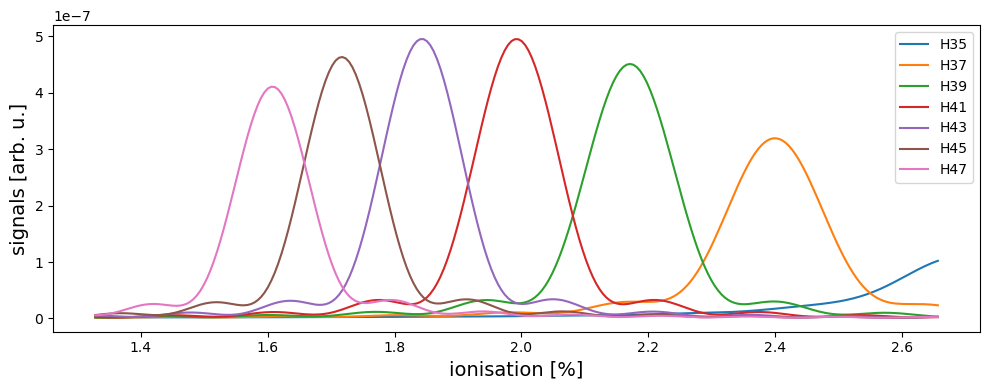

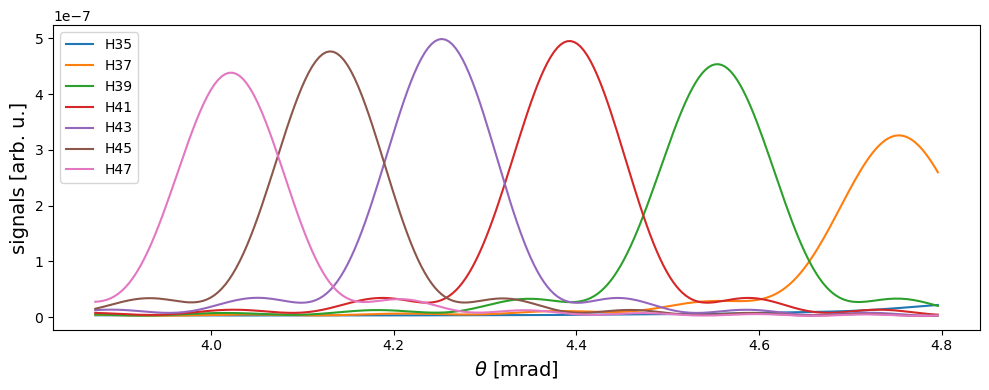

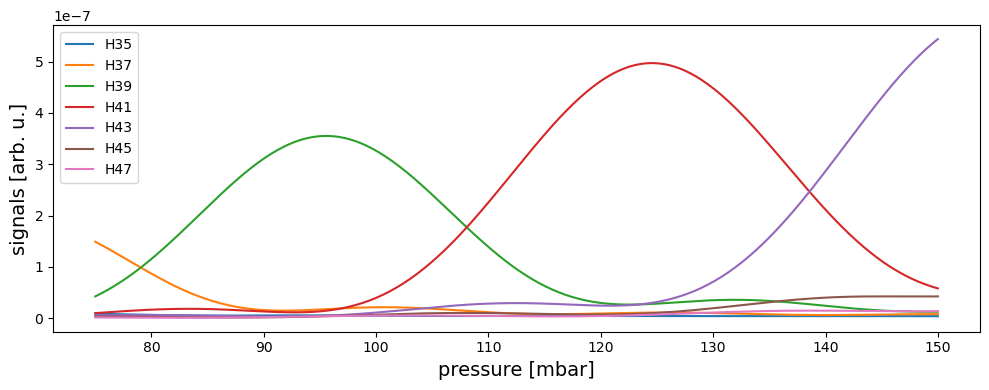

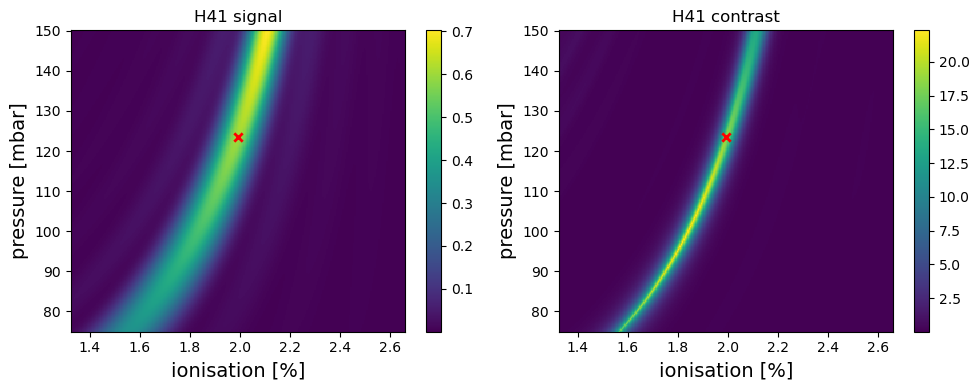

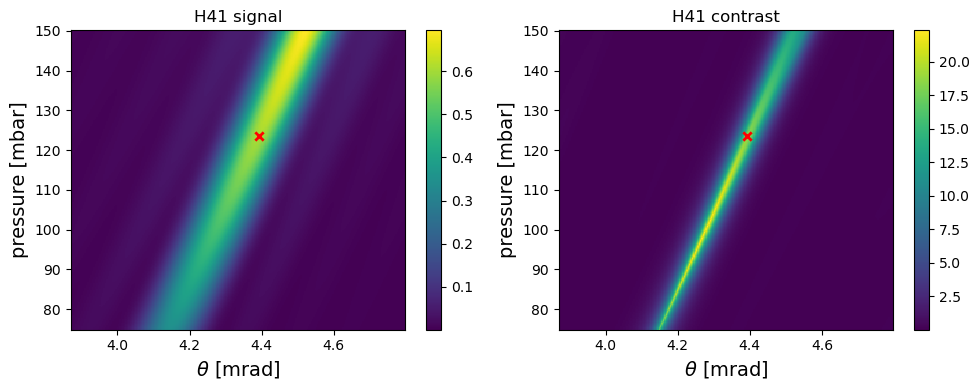

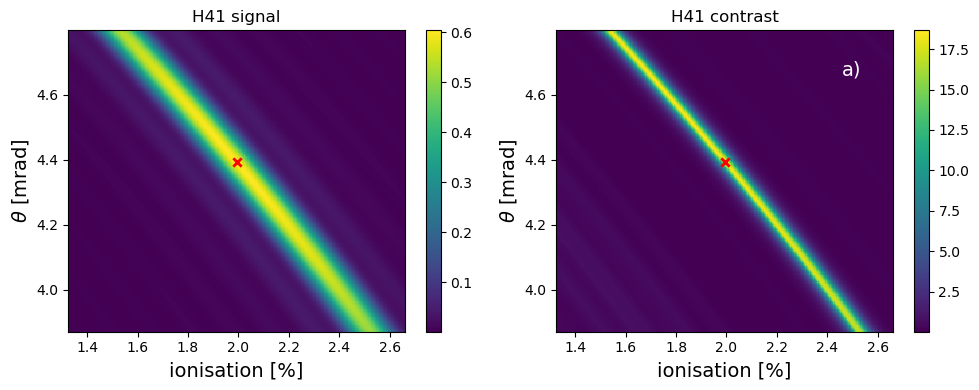

In [6]:
## grids of parameters
zeta_grid = np.linspace(0.75e-5,1.15e-5,250)
pressure_grid = np.linspace(75e-3,150e-3,250)
eta_grid = np.linspace(0.5*eta_opt,eta_opt,250)

# harmonics of the interest on the grids
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("ionisation [%]", fontsize=14)
ax.set_ylabel("signals [arb. u.]", fontsize=14)
for k1 in range(len(H_interest)):
    ax.plot(1e2*eta_grid, XUV_sig.periodic_medium_signal(pressure, zeta_opt, l1, xi_opt, eta_grid, H_interest[k1], M_3Labs, parameters)[1],
            label= r"H"+str(H_interest[k1]))
plt.legend()
plt.tight_layout()
fig.savefig('Signals_stability_eta.pdf')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel(r"$\theta$ [mrad]", fontsize=14)
ax.set_ylabel("signals [arb. u.]", fontsize=14)
for k1 in range(len(H_interest)):
    ax.plot(1e3*XUV_sig.zeta2theta(zeta_grid), XUV_sig.periodic_medium_signal(pressure, zeta_grid, l1, xi_opt, eta_gen, H_interest[k1], M_3Labs, parameters)[1],
            label= r"H"+str(H_interest[k1]))
plt.legend()

plt.tight_layout()
fig.savefig('Signals_stability_theta.pdf')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("pressure [mbar]", fontsize=14)
ax.set_ylabel("signals [arb. u.]", fontsize=14)
for k1 in range(len(H_interest)):
    ax.plot(1e3*pressure_grid, XUV_sig.periodic_medium_signal(pressure_grid, zeta_opt, l1, xi_opt, eta_gen, H_interest[k1], M_3Labs, parameters)[1],
            label= r"H"+str(H_interest[k1]))
plt.legend()

plt.tight_layout()
fig.savefig('Signals_stability_pressure.pdf')
plt.show()


# 2D- plots
# pressure-ionisation
signals = []
for k1 in range(len(H_interest)):
    signals.append(np.zeros((len(pressure_grid),len(eta_grid))))
    for k2 in range(len(pressure_grid)):
        signals[k1][k2,:] = XUV_sig.periodic_medium_signal(pressure_grid[k2], zeta_opt, l1, xi_opt, eta_grid, H_interest[k1], M_3Labs, parameters)[1]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
im = ax[0].pcolormesh(1e2*eta_grid, 1e3*pressure_grid, signals[H_interest.index(H_opt)]/sig_norm)
ax[0].set_ylabel("pressure [mbar]", fontsize=14)
ax[0].set_xlabel("ionisation [%]", fontsize=14)
ax[0].set_title('H'+str(H_opt)+' signal')
plt.colorbar(im, ax=ax[0])


im = ax[1].pcolormesh(1e2*eta_grid, 1e3*pressure_grid,
                 XUV_sig.monochrom_function(H_interest,signals,H_opt,H_compare, metric = 'max')) #signals[H_interest.index(H_opt)])
ax[1].set_ylabel("pressure [mbar]", fontsize=14)
ax[1].set_xlabel("ionisation [%]", fontsize=14)
ax[1].set_title('H'+str(H_opt)+' contrast')
plt.colorbar(im, ax=ax[1])

ax[0].scatter(1e2*eta_gen, 1e3*pressure, c='r',marker='x',linewidths=2)
ax[1].scatter(1e2*eta_gen, 1e3*pressure, c='r',marker='x',linewidths=2)

plt.tight_layout()
fig.savefig('Signals_stability_eta-pressure.pdf')


# pressure-zeta
signals = []
for k1 in range(len(H_interest)):
    signals.append(np.zeros((len(pressure_grid),len(zeta_grid))))
    for k2 in range(len(pressure_grid)):
        signals[k1][k2,:] = XUV_sig.periodic_medium_signal(pressure_grid[k2], zeta_grid, l1, xi_opt, eta_gen, H_interest[k1], M_3Labs, parameters)[1]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
im = ax[0].pcolormesh(1e3*XUV_sig.zeta2theta(zeta_grid), 1e3*pressure_grid, signals[H_interest.index(H_opt)]/sig_norm)
ax[0].set_ylabel("pressure [mbar]", fontsize=14)
ax[0].set_xlabel(r"$\theta$ [mrad]", fontsize=14)
ax[0].set_title('H'+str(H_opt)+' signal')
plt.colorbar(im, ax=ax[0])


im = ax[1].pcolormesh(1e3*XUV_sig.zeta2theta(zeta_grid), 1e3*pressure_grid,
                 XUV_sig.monochrom_function(H_interest,signals,H_opt,H_compare, metric = 'max')) #signals[H_interest.index(H_opt)])
ax[1].set_ylabel("pressure [mbar]", fontsize=14)
ax[1].set_xlabel(r"$\theta$ [mrad]", fontsize=14)
ax[1].set_title('H'+str(H_opt)+' contrast')
plt.colorbar(im, ax=ax[1])

ax[0].scatter(1e3*XUV_sig.zeta2theta(zeta_opt), 1e3*pressure, c='r',marker='x',linewidths=2)
ax[1].scatter(1e3*XUV_sig.zeta2theta(zeta_opt), 1e3*pressure, c='r',marker='x',linewidths=2)

plt.tight_layout()
fig.savefig('Signals_stability_pressure-zeta.pdf')


# zeta-ionisation
signals = []
for k1 in range(len(H_interest)):
    signals.append(np.zeros((len(zeta_grid),len(eta_grid))))
    for k2 in range(len(zeta_grid)):
        signals[k1][k2,:] = XUV_sig.periodic_medium_signal(pressure, zeta_grid[k2], l1, xi_opt, eta_grid, H_interest[k1], M_3Labs, parameters)[1]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
im = ax[0].pcolormesh(1e2*eta_grid, 1e3*XUV_sig.zeta2theta(zeta_grid), signals[H_interest.index(H_opt)]/sig_norm)
ax[0].set_ylabel(r"$\theta$ [mrad]", fontsize=14)
ax[0].set_xlabel("ionisation [%]", fontsize=14)
ax[0].set_title('H'+str(H_opt)+' signal')
plt.colorbar(im, ax=ax[0])


im = ax[1].pcolormesh(1e2*eta_grid, 1e3*XUV_sig.zeta2theta(zeta_grid),
                 XUV_sig.monochrom_function(H_interest,signals,H_opt,H_compare, metric = 'max')) #signals[H_interest.index(H_opt)])
ax[1].set_ylabel(r"$\theta$ [mrad]", fontsize=14)
ax[1].set_xlabel("ionisation [%]", fontsize=14)
ax[1].set_title('H'+str(H_opt)+' contrast')
plt.colorbar(im, ax=ax[1])

ax[0].scatter(1e2*eta_gen, 1e3*XUV_sig.zeta2theta(zeta_opt),c='r',marker='x',linewidths=2)
ax[1].scatter(1e2*eta_gen, 1e3*XUV_sig.zeta2theta(zeta_opt),c='r',marker='x',linewidths=2)

# Annotation, used in the paper.
ax[1].annotate('a)',xy=(.85,.85),fontsize=14,color='w',xycoords='axes fraction')

plt.tight_layout()
fig.savefig('Signals_stability_eta-zeta.pdf')